## Unbalanced Gromov-Wasserstein for SNARE-seq example

To simulate imbalance between cell types, we subsample the ATAC dataset and try to align to the full RNA dataset.

In [1]:
import sys
sys.path.insert(1, '../src/')
import utils as ut
import evals as evals
import scot2 as sc
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

In [2]:
X=np.load("../data/scatac_feat.npy") 
y=np.load("../data/scrna_feat.npy")
print("Dimensions of input datasets are: ", "X= ", X.shape, " y= ", y.shape)

Dimensions of input datasets are:  X=  (1047, 19)  y=  (1047, 10)


In [3]:
X=ut.unit_normalize(X)
y=ut.unit_normalize(y)

Can't find the cell-type information for now, so assign cluster labels based on spectral clustering. This seems relatively clean...

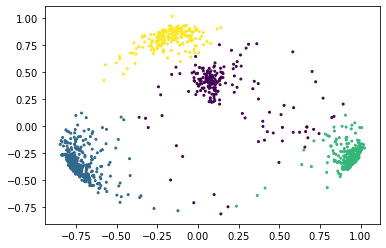

In [4]:
pca=PCA(n_components=2)
y_pca = pca.fit_transform(y)

clustering = SpectralClustering(n_clusters = 4, assign_labels = "discretize", random_state = 0).fit(y_pca)
plt.scatter(y_pca[:, 0], y_pca[:, 1], s = 4, c = clustering.labels_)

Now subsample the ATAC data according to class proportions `props`

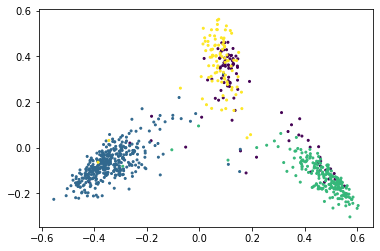

In [5]:
props = [0.5, 1, 0.75, 0.5]
index = np.concatenate([np.where(clustering.labels_ == i)[0][0:int((clustering.labels_ == i).sum() * props[i])] for i in range(len(props))])
X_subsamp = X[index, :]

X_subsamp_pca = pca.fit_transform(X_subsamp)
plt.scatter(X_subsamp_pca[:, 0], X_subsamp_pca[:, 1], s = 4, c = clustering.labels_[index])

In [6]:
# initialize SCOT object
scot=sc.SCOT(X_subsamp, y)

Align using balanced and unbalanced Gromov-Wasserstein

In [7]:
# call the unbalanced alignment 
X_new_bal, y_new_bal = scot.align(k=50, e=0.0005,  normalize=False)

It.  |Err         
-------------------
    0|2.512857e-03|
   10|9.632699e-04|
   20|2.201648e-04|
   30|9.146903e-05|
   40|5.387046e-05|
   50|4.225666e-05|
   60|3.867948e-05|
   70|3.756788e-05|
   80|3.603410e-05|
   90|3.265532e-05|
  100|2.762011e-05|
  110|2.198783e-05|
  120|1.672659e-05|
  130|1.233497e-05|
  140|8.915730e-06|
  150|6.364020e-06|
  160|4.507601e-06|
  170|3.177430e-06|
  180|2.233025e-06|
  190|1.566256e-06|
It.  |Err         
-------------------
  200|1.097156e-06|
  210|7.678714e-07|
  220|5.370787e-07|
  230|3.754859e-07|
  240|2.624269e-07|
  250|1.833662e-07|
  260|1.281013e-07|
  270|8.948096e-08|
  280|6.249785e-08|
  290|4.364833e-08|
  300|3.048220e-08|
  310|2.128664e-08|
  320|1.486465e-08|
  330|1.037988e-08|
  340|7.248070e-09|
  350|5.061123e-09|
  360|3.534005e-09|
  370|2.467654e-09|
  380|1.723055e-09|
  390|1.203129e-09|
It.  |Err         
-------------------
  400|8.400865e-10|


In [9]:
X_new_unbal, y_new_unbal = scot.align(k=50, e=1e-3, rho = 0.0005, normalize=False, balanced = False)

It.  |Err         
-------------------
    0|1.104449e-03|


/home/rebecca/Documents/ManifoldAlignment/venv/lib/python3.7/site-packages/ot/unbalanced.py:394: RuntimeWarning: divide by zero encountered in true_divide
  u = (a / Kv) ** fi
/home/rebecca/Documents/ManifoldAlignment/venv/lib/python3.7/site-packages/ot/unbalanced.py:403: UserWarning: Numerical errors at iteration 0
  warnings.warn('Numerical errors at iteration %s' % i)


   10|0.000000e+00|


../src/scot2.py:183: RuntimeWarning: invalid value encountered in true_divide
  self.coupling=self.coupling / np.sum(self.coupling)


We have aligned the ATAC dataset (subsampled) onto the RNA dataset (full).

In [11]:
pca=PCA(n_components=2)
Xy_pca_bal=pca.fit_transform(np.concatenate((X_new_bal, y_new), axis=0))
X_pca_bal=Xy_pca_bal[0:X_new_bal.shape[0],]
y_pca_bal=Xy_pca_bal[X_new_bal.shape[0]:,]
Xy_pca_unbal=pca.fit_transform(np.concatenate((X_new_unbal, y_new), axis=0))
X_pca_unbal=Xy_pca_unbal[0:X_new_unbal.shape[0],]
y_pca_unbal=Xy_pca_unbal[X_new_unbal.shape[0]:,]

### Read in cell type information:
# Xlabels=np.genfromtxt("data/SNAREseq_typesChromatin.txt")
# ylabels=np.genfromtxt("data/SNAREseq_typesExpression.txt")

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 5))
ax1.scatter(y_pca_bal[:,0], y_pca_bal[:,1], s=15, label="Gene Expression", alpha = 0.5, c = clustering.labels_, marker = "+")
ax1.set_title("Expression")

ax2.scatter(X_pca_unbal[:,0], X_pca_unbal[:,1], s=15, label="Chromatin Accessibility", alpha = 0.5, c = clustering.labels_[index], marker = "^")
ax2.set_title("ATAC, unbalanced")

ax3.scatter(X_pca_bal[:,0], X_pca_bal[:,1], s=15, label="Chromatin Accessibility", alpha = 0.5, c = clustering.labels_[index], marker = "^")
ax3.set_title("ATAC, balanced")

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 3 dimension(s)

For a (row-normalised) coupling $P$, we can compute the expected class membership error:
$$\mathbf{E}_{(x, y) \sim P} \mathbf{1}\{ \mathrm{class}(x) \ne \mathrm{class}(y) \}$$

In [90]:
P_unbal = (gamma_unbal.T/gamma_unbal.sum(1)).T
mean_err_unbal = (P_unbal*(clustering.labels_[index, None] != clustering.labels_[None, :])).sum(1).mean()
P_bal = (gamma_bal.T/gamma_bal.sum(1)).T
mean_err_bal = (P_bal*(clustering.labels_[index, None] != clustering.labels_[None, :])).sum(1).mean()

In [92]:
print("unbalanced: %f, balanced: %f" % (mean_err_unbal, mean_err_bal))

unbalanced: 0.138904, balanced: 0.254218
